In [1]:
import rdkit

from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import MCS
from rdkit.Chem import rdFMCS
from rdkit.Chem import Draw
from rdkit.Chem import *
IPythonConsole.ipython_useSVG=False  

import os
from os import listdir
from os.path import isfile, join

from PIL import Image, ImageDraw, ImageFont
import PIL

import numpy as np
from IPython.display import Image 
import math

from copy import deepcopy

from rdkit.Chem import AllChem, Draw, rdFMCS
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Draw import IPythonConsole

from IPython.display import SVG


C:\Users\josef\AppData\Local\Temp/ipykernel_30716/4055684996.py:5: DeprecationWarning: The rdkit.Chem.MCS module is deprecated; please use rdkit.Chem.rdFMCS instead.
  from rdkit.Chem import MCS


In [2]:
import networkx as nx
import logging
logger = logging.getLogger(__name__)

# General function for finding the common core of two molecules, creating dictionaries, converting rdkit-mol to networkx-graph etc. 

#### create additional dictionaries/properties for a mol object (the goal is identity between the mol-objects of the notebook and Transformato):

In [3]:
def generate_apply_dicts(
    mol
) :
    """
    Generate mapping dictionaries for a molecule in a psf.
    Parameters
    ----------
    psf: pm.charmm.CharmmPsfFile
    Returns
    ----------
    dict's
    """

    atom_idx_to_atom_name = dict()
    atom_name_to_atom_idx = dict()
    atom_name_to_atom_type = dict()
    atom_idx_to_atom_partial_charge = dict()

    for atom in mol.GetAtoms():
        atom_name = atom.GetSymbol()
      #  atom_name = atom.GetAtomicNum()
        atom_index = atom.GetIdx()
        atom_type = atom.GetSymbol()
        atom_charge = atom.GetFormalCharge()

        atom_idx_to_atom_name[atom_index] = atom_name
        atom_name_to_atom_idx[atom_name] = atom_index
        atom_name_to_atom_type[atom_name] = atom_type
        atom_idx_to_atom_partial_charge[atom_index] = atom_charge

    for atom in mol.GetAtoms():
 
        atom.SetProp("atom_name", atom_idx_to_atom_name[atom.GetIdx()])
        atom.SetProp(
            "atom_type",
            atom_name_to_atom_type[atom_idx_to_atom_name[atom.GetIdx()]],
        )
        atom.SetProp("atom_index", str(atom.GetIdx()))
        atom.SetProp(
            "atom_charge", str(atom_idx_to_atom_partial_charge[atom.GetIdx()])
        )
    return mol




### diverse functions for converting rdkit-mol object to networkx-graph object

In [4]:
def mol_to_nx(mol):
    G = nx.Graph()

    for atom in mol.GetAtoms():
        G.add_node(atom.GetIdx(),
                   atomic_num=atom.GetAtomicNum(),
                   is_aromatic=atom.GetIsAromatic(),
                   atom_symbol=atom.GetSymbol())
        
    for bond in mol.GetBonds():
        G.add_edge(bond.GetBeginAtomIdx(),
                   bond.GetEndAtomIdx(),
                   bond_type=bond.GetBondType())
        
    return G

In [5]:
def _mol_to_nx_full(mol):
    G = nx.Graph()


    #to get same representation in networkx as in Transformato (copied from mutate.py)
    atoms = mol.GetNumAtoms()
    for idx in range(atoms):
        mol.GetAtomWithIdx(idx).SetProp(
            "molAtomMapNumber2", str(mol.GetAtomWithIdx(idx).GetIdx())
        )

    for atom in mol.GetAtoms():
        G.add_node(
            atom.GetIdx(),
            atomic_num=atom.GetAtomicNum(),
            formal_charge=atom.GetFormalCharge(),
            chiral_tag=atom.GetChiralTag(),
            hybridization=atom.GetHybridization(),
            num_explicit_hs=atom.GetNumExplicitHs(),
            is_aromatic=atom.GetIsAromatic(),
          
            atomic_id = atom.GetIdx(),
            atom_symbol=atom.GetSymbol(),

            atom_map = atom.GetProp("molAtomMapNumber2"),
            
            #additionally

            atom_index = atom.GetProp("atom_index"),

            atom_type = atom.GetProp("atom_type"),

            atom_index_type = str(atom.GetProp("atom_type")) + ":" + str(atom.GetProp("atom_index"))


          #  str(i.GetProp("atom_index")) + ":" + i.GetProp("atom_type")

        )

    for bond in mol.GetBonds():
        G.add_edge(
            bond.GetBeginAtomIdx(),
            bond.GetEndAtomIdx(),
            bond_type=bond.GetBondType(),
        )
    return G

In [6]:
#also weights are added (necessary for new mutation algorithms)
def _mol_to_nx_full_weight(mol):
    G = nx.Graph()


    #to get same representation in networkx as in transformato(copied from mutate.py)
    atoms = mol.GetNumAtoms()
    for idx in range(atoms):
        mol.GetAtomWithIdx(idx).SetProp(
            "molAtomMapNumber2", str(mol.GetAtomWithIdx(idx).GetIdx())
        )

    for atom in mol.GetAtoms():
        G.add_node(
            atom.GetIdx(),
            atomic_num=atom.GetAtomicNum(),
            formal_charge=atom.GetFormalCharge(),
            chiral_tag=atom.GetChiralTag(),
            hybridization=atom.GetHybridization(),
            num_explicit_hs=atom.GetNumExplicitHs(),
            is_aromatic=atom.GetIsAromatic(),
           
            atomic_id = atom.GetIdx(),
            atom_symbol=atom.GetSymbol(),

            atom_map = atom.GetProp("molAtomMapNumber2"),
            
            #additionally

            atom_index = atom.GetProp("atom_index"),

            atom_type = atom.GetProp("atom_type"),

            atom_index_type = str(atom.GetProp("atom_type")) + ":" + str(atom.GetProp("atom_index"))


          #  str(i.GetProp("atom_index")) + ":" + i.GetProp("atom_type")

        )

    for bond in mol.GetBonds():
        G.add_edge(
            bond.GetBeginAtomIdx(),
            bond.GetEndAtomIdx(),
            bond_type=bond.GetBondType(),
            
            weight = 5
        )
    return G

## get the common core of two molecules (rdkit-mols)

In [7]:
def get_common_core(mol1, mol2):
    mols = [mol1, mol2]
    
    res=rdFMCS.FindMCS(mols, ringMatchesRingOnly = True, completeRingsOnly = True, ringCompare=rdkit.Chem.rdFMCS.RingCompare.StrictRingFusion )    
    substructure = Chem.MolFromSmarts(res.smartsString)
    #res=rdFMCS.FindMCS(mols, ringMatchesRingOnly = True, completeRingsOnly = True )    

    
    ccore = MolFragmentToCXSmiles(mol1, mol1.GetSubstructMatch(substructure), kekuleSmiles = True, isomericSmiles=False)
    ccoremol = Chem.MolFromSmiles(ccore)
    
    hit_ats1 = mol1.GetSubstructMatch(substructure)
    hit_bonds1 = []
    for bond in substructure.GetBonds():
        aid1 = hit_ats1[bond.GetBeginAtomIdx()]
        aid2 = hit_ats1[bond.GetEndAtomIdx()]
        hit_bonds1.append(mol1.GetBondBetweenAtoms(aid1,aid2).GetIdx())
    

    hit_ats2 = mol2.GetSubstructMatch(substructure)
    hit_bonds2 = []
    for bond in substructure.GetBonds():
        aid1 = hit_ats2[bond.GetBeginAtomIdx()]
        aid2 = hit_ats2[bond.GetEndAtomIdx()]
        hit_bonds2.append(mol2.GetBondBetweenAtoms(aid1,aid2).GetIdx())
        
    
    mol1coreindex = [hit_ats1]
    mol2coreindex= [hit_ats2]
    
    return mol1coreindex, mol2coreindex, hit_ats1, hit_ats2
    

## functions prior to the mutation route step: find connected dummy regions and terminal atoms, etc.
### mostly from Transformato, however slightly modified (especially no reference to proposed_mutation_route and systemstructure objects)

In [8]:
def _find_connected_dummy_regions_mol(mol, ccore, G):

 
    sub=ccore
    G_dummy = G.copy()
    
    
    from itertools import chain
    sub = [int(x) for x in chain.from_iterable(ccore)]
  
    # find all dummy atoms
    list_of_dummy_atoms_idx = [
        atom.GetIdx() for atom in mol.GetAtoms() if atom.GetIdx() not in sub
    ]
    nr_of_dummy_atoms = len(list_of_dummy_atoms_idx) + 1
    list_of_real_atoms_idx = [
        atom.GetIdx() for atom in mol.GetAtoms() if atom.GetIdx() in sub
    ]
    
    print("list_of_dummy_atoms_idx")
    print(list_of_dummy_atoms_idx)

    print("nr_of_dummy_atoms")
    print(nr_of_dummy_atoms)
    
    print("list_of_real_atoms_idx")
    print(list_of_real_atoms_idx)

    
    # remove real atoms from graph to obtain multiple connected compounds
    for real_atom_idx in list_of_real_atoms_idx:
        G_dummy.remove_node(real_atom_idx)

    # find these connected compounds
    from networkx.algorithms.components import connected_components

    unique_subgraphs = [
        c for c in sorted(nx.connected_components(G_dummy), key=len, reverse=True)
    ]
    
    return unique_subgraphs, G_dummy

In [9]:
def _find_terminal_atom(cc_idx, mol):
    """
    Find atoms that connect the molecule to the common core.

    Args:
        cc_idx (list): common core index atoms
        mol ([type]): rdkit mol object
    """
    terminal_dummy_atoms = []
    terminal_real_atoms = []
    
    from itertools import chain
    cc_idx = [int(x) for x in chain.from_iterable(cc_idx)]

    for atom in mol.GetAtoms():
        idx = atom.GetIdx()
      
        
        if idx not in cc_idx:
            neighbors = [x.GetIdx() for x in atom.GetNeighbors()]
            if any([n in cc_idx for n in neighbors]):
                terminal_dummy_atoms.append(idx)
        if idx in cc_idx:
            neighbors = [x.GetIdx() for x in atom.GetNeighbors()]
            if any([n not in cc_idx for n in neighbors]):
                terminal_real_atoms.append(idx)

    logger.info(f"Terminal dummy atoms: {str(list(set(terminal_dummy_atoms)))}")
    logger.info(f"Terminal real atoms: {str(list(set(terminal_real_atoms)))}")

    return (list(set(terminal_dummy_atoms)), list(set(terminal_real_atoms)))

In [10]:
def _match_terminal_real_and_dummy_atoms(mol, real_atoms_cc, dummy_atoms_cc):
#      mol, real_atoms_cc: list, dummy_atoms_cc: list
#   ) -> dict:
    """
    Matches the terminal real and dummy atoms and returns a dict with real atom idx as key and a set of dummy atoms that connect
    to this real atom as a set

    Parameters
    ----------
    mol : [Chem.Mol]
        The mol object with the real and dummy atoms
    real_atoms_cc : list
        list of real atom idx
    dummy_atoms_cc : list
        list of dummy atom idx

    Returns
    -------
    [type]
        [description]
    """

    from collections import defaultdict

    real_atom_match_dummy_atom = defaultdict(set)
    for real_atom_idx in real_atoms_cc:
        real_atom = mol.GetAtomWithIdx(real_atom_idx)
        real_neighbors = [x.GetIdx() for x in real_atom.GetNeighbors()]
        for dummy_atoms_idx in dummy_atoms_cc:
            if dummy_atoms_idx in real_neighbors:
                real_atom_match_dummy_atom[real_atom_idx].add(dummy_atoms_idx)
                

    return real_atom_match_dummy_atom

###  fully new function: again check for connected components after matching real and dummy atoms (only necessary for pathological cases where two atoms of the same component are connected to the common core)


In [11]:
def reduce_terminal(match_terminal_atoms, subg, G_dummy):
    #new: again check for connected components (only necessary for pathological cases where two atoms of the same component are connected to the common core)
    from networkx.algorithms.components import connected_components

    coreconnectingnodes = []
    
    for nodes in match_terminal_atoms.values():
        aequinodes = []
     
        for node in nodes:
            coreconnectingnodes.append(node)
          
        for i in range(len(coreconnectingnodes)):
        
            for j in range(i, len(coreconnectingnodes)):
            
                if (i != j ):
                   
                    if (nx.has_path(G_dummy,coreconnectingnodes[i],coreconnectingnodes[j])):
                       
                        nodes.remove(coreconnectingnodes[i])
                                  
        coreconnectingnodes = []
    
    return match_terminal_atoms

# Mutation Route Algorithms (i.e. the most important part)

## 3 main approaches (_calculate_order_of_LJ_mutations, _calculate_order_of_LJ_mutations_new and _calculate_order_of_LJ_mutations_iter):
### _calculate_order_of_LJ_mutations: naive dfs (as currently in transformato)
### _calculate_order_of_LJ_mutations_new: bfs/djikstra-algorithm applied once for route
### _calculate_order_of_LJ_mutations_new_iter: bfs/djikstra-algorithm applied iteratively, i.e. after each removal of an atom 

In [12]:
def _calculate_order_of_LJ_mutations(
    connected_dummy_regions: list, match_terminal_atoms: dict, G: nx.Graph
) -> list:

    ordered_LJ_mutations = []
    for real_atom in match_terminal_atoms:
        for dummy_atom in match_terminal_atoms[real_atom]:
            for connected_dummy_region in connected_dummy_regions:
                # stop at connected dummy region with specific dummy_atom in it
                if dummy_atom not in connected_dummy_region:
                    continue

                G_dummy = G.copy()
                # delete all nodes not in dummy region
                remove_nodes = [
                    node for node in G.nodes() if node not in connected_dummy_region
                ]
                for remove_node in remove_nodes:
                    G_dummy.remove_node(remove_node)

                # root is the dummy atom that connects the real region with the dummy region
                root = dummy_atom

                edges = list(nx.dfs_edges(G_dummy, source=root))
                nodes = [root] + [v for u, v in edges]
                nodes.reverse()  # NOTE: reverse the mutation
                ordered_LJ_mutations.append(nodes)

    return ordered_LJ_mutations

In [13]:
def _calculate_order_of_LJ_mutations_new(
    connected_dummy_regions: list, match_terminal_atoms: dict, G: nx.Graph, cyclecheck=True, ordercycles=True
) -> list:

    ordered_LJ_mutations = []
    
    final_orders = []
    
    
    for real_atom in match_terminal_atoms:
        for dummy_atom in match_terminal_atoms[real_atom]:
            for connected_dummy_region in connected_dummy_regions:
                # stop at connected dummy region with specific dummy_atom in it
                if dummy_atom not in connected_dummy_region:
                    continue

                G_dummy = G.copy()
                # delete all nodes not in dummy region
                remove_nodes = [
                    node for node in G.nodes() if node not in connected_dummy_region
                ]
                for remove_node in remove_nodes:
                    G_dummy.remove_node(remove_node)

                # root is the dummy atom that connects the real region with the dummy region
                root = dummy_atom
                
                #process cycles
                if (cyclecheck == True and ordercycles==False):
                    G_dummy = cycle_checks_nx(G_dummy)
                
                #process cycles and correct order (according to 'preferential removal')
                if (cyclecheck == True and ordercycles==True):
                    cycledict, degreedict = cycle_checks(G_dummy)
                             
                        
                #dijkstra          
                ssource = nx.single_source_dijkstra(G_dummy, source=root, weight='weight')
     
                sortedssource = {k: v for k, v in sorted(ssource[0].items(), key=lambda item: item[1])}   
    
                max_node = max(ssource[0], key=ssource[0].get)
                      
                sortedssource_edges = sortedssource.keys()

                sortedssource_edges_list = list(sortedssource_edges)
                 
                nodes = sortedssource_edges_list
            
                nodes.reverse()  
                
                #sort nodes according to degree, cycle participation and removal order
                if (cyclecheck == True and ordercycles==True):
                    nodes = change_route_cycles(nodes, cycledict, degreedict, sortedssource, G)
             
                
                print("Final mutation route:")
                print(nodes)
                ordered_LJ_mutations.append(nodes)

    return ordered_LJ_mutations

In [14]:
def _calculate_order_of_LJ_mutations_new_iter(
    connected_dummy_regions: list, match_terminal_atoms: dict, G: nx.Graph, cyclecheck=True, ordercheck=True
) -> list:

    ordered_LJ_mutations = []
    
    final_orders = []
    
    
    
    for real_atom in match_terminal_atoms:
        for dummy_atom in match_terminal_atoms[real_atom]:
            for connected_dummy_region in connected_dummy_regions:
                # stop at connected dummy region with specific dummy_atom in it
                if dummy_atom not in connected_dummy_region:
                    continue

                G_dummy = G.copy()
                # delete all nodes not in dummy region
                remove_nodes = [
                    node for node in G.nodes() if node not in connected_dummy_region
                ]
                for remove_node in remove_nodes:
                    G_dummy.remove_node(remove_node)

                # root is the dummy atom that connects the real region with the dummy region
                root = dummy_atom

           
                
                final_order = []
                
                removeG = nx.Graph()
                removearray = []
                while ( len(G_dummy.nodes())  > 0):
                    #update weights according to already removed nodes
                    if (ordercheck == True):
                        G_dummy = order_checks_nx(G_dummy, removearray, G)
                    
                    G_origweights = G_dummy.copy()
                    
                    #update weights according to cycle participation
                    if (cyclecheck == True):
                        G_dummy = cycle_checks_nx(G_dummy)
                   

                    
                    #dijkstra    
                    ssource = nx.single_source_dijkstra(G_dummy, source=root, weight='weight')

                    sortedssource = {k: v for k, v in sorted(ssource[0].items(), key=lambda item: item[1])}
                    max_node = max(ssource[0], key=ssource[0].get)
            
                    final_order.extend([max_node])
                    
                    
                    #restore original weights
                    G_dummy = G_origweights
                    
                    #remove G_dummy
                    G_dummy.remove_node(max_node)
                    
                    #add to removeG
                    removeG.add_node(max_node)
                    removearray.append(max_node)
                    
                    sortedssource_edges = final_order
                    
              
                #sortedssource_edges_list already contains the nodes in right (reversed) order (including root)
                nodes = sortedssource_edges
                
                print("Final mutation route:")
                print(nodes)
                
                #no reverse (already correct order, starting with the node with greatest distance from root)
                ordered_LJ_mutations.append(nodes)
                
               

    return ordered_LJ_mutations

### additional functions for the new mutation route algorithms (using weight updates, cycle and degree functions of networkx): process cycles (atoms participating in many cycles are removed later) and 'preferential removal' (atoms which neighbours already have been removed are removed earlier)

In [15]:
#cycle processing, currently used in _calculate_order_of_LJ_mutations_new_iter 
def cycle_checks_nx(G):
    
    #search cycles using networkx
    cycles = nx.cycle_basis(G)
    
    import collections
    from collections import Counter
    
    cdict = Counter(x for xs in cycles for x in set(xs))
  
    
    #modify weighted graph: nodes participating in many cycles get lower weight
    for i in cdict:
        edg = G.edges(i)
        for el in edg:
            G[el[0]][el[1]]['weight'] = G[el[0]][el[1]]['weight'] - cdict[i]*0.5
    
    return G

In [16]:
#preferential removal, currently used in _calculate_order_of_LJ_mutations_new_iter 
def order_checks_nx(G, removearray, G_total):
    if (len(removearray) > 0):
        lastremoved = removearray[len(removearray) - 1]
        
        edg = G_total.edges(lastremoved)
        
        edg_dummy = G.edges()
        
        for ed in edg:
       
            if (ed[0]!=lastremoved):
                connectednode = ed[0]
            else:
                connectednode = ed[1]
            
            #if node is connected to last removed node, its weight get a small increase
            if (G.has_node(connectednode)):
             
                connectededges = G.edges(connectednode)
                for el in connectededges:
                   
                    G[el[0]][el[1]]['weight'] = G[el[0]][el[1]]['weight'] + 0.1
                                    
            
    return G

In [17]:
#cycle processing dictionary and degree dictionary for preferential removal, currently used in _calculate_order_of_LJ_mutations_new (via change_route_cycles)
def cycle_checks(G):
    
    
    #search cycles using networkx
    cycles = nx.cycle_basis(G)
    
    #alternatively, using rdkit
    #ri = mol.GetRingInfo()
    #cyclesrdkit = ri.AtomRings()
    
    import collections
    from collections import Counter
    
    cdict = Counter(x for xs in cycles for x in set(xs))
    #cdictrdkit = Counter(x for xs in cyclesrdkit for x in set(xs))
    
    #add atoms with no cycle participation
    for key in G.nodes:
        if key not in cdict:
            cdict[key] = 0
    
    degreedict = G.degree()
    degreedict = {node:val for (node, val) in degreedict}      
    
    return cdict, degreedict

In [18]:
#currently used in _calculate_order_of_LJ_mutations_new
#preliminary mutation is list is sorted using cycle and degree dictionary
def change_route_cycles(route, cycledict, degreedict, weightdict, G):

    
    for i in range(len(route)-1):
        routedict = route[i]
        routeweight = weightdict.get(route[i])
        
        routecycleval = cycledict.get(route[i])
        routedegreeval = degreedict.get(route[i])
       
        for j in range(i, len(route)):
       
            if (routeweight == weightdict[route[j]]):
                      
                #if nodes have same weight (i.e. distance from root), the node participating in more cycles is removed later
                
                if (routecycleval > cycledict[route[j]] or (routecycleval == cycledict[route[j]] and routedegreeval > degreedict[route[j]])):
                    idx1 = route.index(route[i])
                    idx2 = route.index(route[j])                  
                    route[idx1], route[idx2] = route[idx2], route[idx1]                 
                    continue
                    
                #if nodes have same weight (i.e. distance from root) and same cycle participation number, the node which has more neighbours already removed is removed earlier

                
                if (routecycleval == cycledict[route[j]]):
                    
                    edgesi = G.edges(routedict)
                    edgesj = G.edges(route[j])

                    iedgecounter = 0
                    for edge in edgesi:
                        if (edge[1] in route[0:i] or edge[0] in route[0:i] ):

                            iedgecounter = iedgecounter + 1

                    jedgecounter = 0
                    for edge in edgesj:
                        if (edge[1] in route[0:i] or edge[0] in route[0:i]):

                            jedgecounter = jedgecounter + 1


                    if (iedgecounter < jedgecounter):
                        idx1 = route.index(route[i])
                        idx2 = route.index(route[j])
                        route[idx1], route[idx2] = route[idx2], route[idx1]

    
    return route

# Visualization functions

### used for color gradient

In [19]:
from colorsys import hls_to_rgb

def rainbow_color_gradient(n=10, end = 1/3):
  #  end=n/40
  #  end = 1/3
    if (n > 1):
        return [ hls_to_rgb(end * i/(n-1), 0.5, 1) for i in range(n) ]
    else:
        return [ hls_to_rgb(end * i/(n), 0.5, 1) for i in range(n) ]

### function for drawing the molecule with color gradient for mutation order


In [20]:
def _show_common_core_gradient( mol, highlight, mutationl, percomponent = False, numbers = False):
    
    """
    Draw the molecule with color gradient for mutation order
    
    highlight: list indicating the ccore, fct highlights the common core in black
    mutationl: list indicating the mutation order, fct draws color gradient
    
    percompoentn: boolean; one color gradient for each component (False) or one for all dummy atoms
    - currently, the components are processed successively, so perhaps True is better suited to illustrate the mutation order
    
    numbers: boolean; show also numbers showing the mutation order
    """
  
    # https://rdkit.blogspot.com/2015/02/new-drawing-code.html

    mol = deepcopy(mol)
    AllChem.Compute2DCoords(mol)

    drawer = rdMolDraw2D.MolDraw2DSVG(800, 800)


    #new
    drawer.drawOptions().setHighlightColour((0.8,0.8,0.8))

    drawer.SetFontSize(0.3)

    opts = drawer.drawOptions()

    for i in mol.GetAtoms():
        opts.atomLabels[i.GetIdx()] = (
            str(i.GetProp("atom_index")) + ":" + i.GetProp("atom_type")
        )

    colours = [(0.8,0.0,0.8),(0,0.15,0),(0,0.8,0.8),(0,0,0.8)]
    atom_cols = {}
    for i, at in enumerate(highlight): 
        atom_cols[at] = colours[1]
    
    if (percomponent == False):
        mutationlflat =  [item for sublist in mutationl for item in sublist]
       
        #colour gradient
        rcolours = rainbow_color_gradient(n=len(mutationlflat))

        colours = [(0.8,0.0,0.8),(0.8,0.8,0),(0,0.8,0.8),(0,0,0.8)]
        for i, at in enumerate(mutationlflat):
            atom_cols[at] = rcolours[i]
        
        if (numbers == True):
            atomlist = mol.GetAtoms()
            for i, at in enumerate(mutationlflat):           
                mnr = i+1
                lbl = '%.0f'%mnr
                atomlist[at].SetProp('atomNote',lbl)


       
        mutationlflat = mutationlflat + list(highlight)
    
        drawer.DrawMolecule(mol, highlightAtoms=mutationlflat, highlightAtomColors=atom_cols)
        Draw.DrawingOptions.includeAtomNumbers = False
        drawer.FinishDrawing()
        svg = drawer.GetDrawingText().replace("svg:", "")
        
        img = Draw.MolToImage(mol,  highlightAtoms=mutationlflat, highlightAtomColors=atom_cols,  useSVG=False)

    
    else:
        mutationlflat =  [item for sublist in mutationl for item in sublist]

        colours = [(0.8,0.0,0.8),(0.8,0.8,0),(0,0.8,0.8),(0,0,0.8)]
        
        componentcount = 0
        for mutcomp in mutationl:
               
                rcolours = rainbow_color_gradient(n=len(mutcomp))
                for i, at in enumerate(mutcomp):
                   
                    atom_cols[at] = rcolours[i]
                    
                componentcount = componentcount+1
                
                
        if (numbers == True):
            atomlist = mol.GetAtoms()
            for i, at in enumerate(mutationlflat):           
                mnr = i+1
                lbl = '%.0f'%mnr
                atomlist[at].SetProp('atomNote',lbl)
                
        mutationlflat = mutationlflat + list(highlight)

       
        drawer.DrawMolecule(mol, highlightAtoms=mutationlflat, highlightAtomColors=atom_cols)
        Draw.DrawingOptions.includeAtomNumbers = False
        drawer.FinishDrawing()
        svg = drawer.GetDrawingText().replace("svg:", "")
        
        img = Draw.MolToImage(mol,  highlightAtoms=mutationlflat, highlightAtomColors=atom_cols, useSVG=False)


    return svg

## almost identical to function above, used for creating visualizations to write in files 

In [21]:
def _show_common_core_gradient_write( mol, highlight, mutationl, percomponent = False):
   

    """
    Draw the molecule with color gradient for mutation order
    
    highlight: list indicating the ccore, fct highlights the common core in black
    mutationl: list indicating the mutation order, fct draws color gradient
    
    percompoentn: boolean; one color gradient for each component (False) or one for all dummy atoms
    - currently, the components are processed successively, so perhaps True is better suited to illustrate the mutation order
    
    numbers: boolean; show also numbers showing the mutation order
    legendtext: string; legend to be placed below molecule
    """
    
    # https://rdkit.blogspot.com/2015/02/new-drawing-code.html

    mol = deepcopy(mol)
    AllChem.Compute2DCoords(mol)

    drawer = rdMolDraw2D.MolDraw2DSVG(300, 300)


    drawer.drawOptions().setHighlightColour((0.8,0.8,0.8))

    drawer.SetFontSize(0.3)

    opts = drawer.drawOptions()

    for i in mol.GetAtoms():
        opts.atomLabels[i.GetIdx()] = (
            str(i.GetProp("atom_index")) + ":" + i.GetProp("atom_type")
        )


    colours = [(0.8,0.0,0.8),(0,0.15,0),(0,0.8,0.8),(0,0,0.8)]
    atom_cols = {}
    for i, at in enumerate(highlight): 
        atom_cols[at] = colours[1]
    
    if (percomponent == False):
        mutationlflat =  [item for sublist in mutationl for item in sublist]
    
        #rainbow colors
        rcolours = rainbow_color_gradient(n=len(mutationlflat))
       
        colours = [(0.8,0.0,0.8),(0.8,0.8,0),(0,0.8,0.8),(0,0,0.8)]
        for i, at in enumerate(mutationlflat):
            atom_cols[at] = rcolours[i]

       
        mutationlflat = mutationlflat + list(highlight)
    
        drawer.DrawMolecule(mol, highlightAtoms=mutationlflat, highlightAtomColors=atom_cols)
        Draw.DrawingOptions.includeAtomNumbers = False
        drawer.FinishDrawing()
        svg = drawer.GetDrawingText().replace("svg:", "")
        
        img = Draw.MolToImage(mol,  highlightAtoms=mutationlflat, highlightAtomColors=atom_cols,  useSVG=False)

    
    else:
        mutationlflat =  [item for sublist in mutationl for item in sublist]

        colours = [(0.8,0.0,0.8),(0.8,0.8,0),(0,0.8,0.8),(0,0,0.8)]
        
        componentcount = 0
        for mutcomp in mutationl:
               
                rcolours = rainbow_color_gradient(n=len(mutcomp))
                for i, at in enumerate(mutcomp):
                   
                    atom_cols[at] = rcolours[i]
                    
                componentcount = componentcount+1
                
        mutationlflat = mutationlflat + list(highlight)

       
        drawer.DrawMolecule(mol, highlightAtoms=mutationlflat, highlightAtomColors=atom_cols)
        Draw.DrawingOptions.includeAtomNumbers = False
        drawer.FinishDrawing()
        svg = drawer.GetDrawingText().replace("svg:", "")
        
        img = Draw.MolToImage(mol,  highlightAtoms=mutationlflat, highlightAtomColors=atom_cols, useSVG=False)

 
    return svg, img


In [22]:
def nxgraph(G):
    mol_attr = nx.get_node_attributes(G, 'atom_index_type')
    #nx.draw(G, with_labels = True)
    nx.draw(G, labels=mol_attr)

### converting files to appropriate format for writing in file

In [23]:
def convertgraphics(img1, img2):
    from cairosvg import svg2png
    from io import BytesIO
    imgn1 = svg2png(img1)
    imgn2 = svg2png(img2)

    import PIL.Image
    imo1 = PIL.Image.open(BytesIO(imgn1))
    imo2 = PIL.Image.open(BytesIO(imgn2))
    
    return imo1, imo2

# Start here!

### interesting example molecules

In [24]:
methylindole2 = "CC1=CC2=CC=CC=C2N1"
neopentane = "CC(C)(C)C"
toluene = "CC1=CC=CC=C1"


ethane = "CC"

methylfuran2 = "CC1=CC=CO1"

cholesterol = "CC(C)CCCC(C)C1CCC2C1(CCC3C2CC=C4C3(CCC(C4)O)C)C"
cortisol = "CC12CCC(=O)C=C1CCC3C2C(CC4(C3CCC4(C(=O)CO)O)C)O"

### or use molecules from the pdbbind-folder

In [25]:
files = os.listdir('pdbbindsdf20/')

In [26]:
print("Folder contains:")
print(files)

Folder contains:
['1a07_ligand.sdf', '1a0q_ligand.sdf', '1a0t_ligand.sdf', '1a1b_ligand.sdf', '1a1c_ligand.sdf', '1a1e_ligand.sdf', '1a2c_ligand.sdf', '1a3e_ligand.sdf', '1a4g_ligand.sdf', '1a4h_ligand.sdf', '1a4k_ligand.sdf', '1a4m_ligand.sdf', '1a4q_ligand.sdf', '1a4r_ligand.sdf', '1a4w_ligand.sdf', '1a5g_ligand.sdf', '1a5h_ligand.sdf', '1a5v_ligand.sdf', '1a7c_ligand.sdf', '1a7t_ligand.sdf']


In [27]:
#sdf to smiles

In [28]:

l1a07sdf = Chem.SDMolSupplier('pdbbindsdf20/' + '1a07_ligand.sdf' )
for i in l1a07sdf:
    l1a07 = Chem.MolToSmiles(i)

l1a1csdf = Chem.SDMolSupplier('pdbbindsdf20/' + '1a1c_ligand.sdf' )
for i in l1a1csdf:
    l1a1c = Chem.MolToSmiles(i)

l1a7csdf = Chem.SDMolSupplier('pdbbindsdf20/' + '1a7c_ligand.sdf' )
for i in l1a7csdf:
    l1a7c = Chem.MolToSmiles(i)
    
#interesting polycycles
l1a4msdf = Chem.SDMolSupplier('pdbbindsdf20/' + '1a4m_ligand.sdf' )
for i in l1a4msdf:
    l1a4m = Chem.MolToSmiles(i)
#ccore with:
l1a7tsdf = Chem.SDMolSupplier('pdbbindsdf20/' + '1a7t_ligand.sdf' )
for i in l1a7tsdf:
    l1a7t = Chem.MolToSmiles(i)
    
l1a0tsdf = Chem.SDMolSupplier('pdbbindsdf20/' + '1a0t_ligand.sdf' )
for i in l1a0tsdf:
    l1a0t = Chem.MolToSmiles(i)

In [29]:
#smiles to rdkit-mol

In [30]:
l1a07mol = Chem.MolFromSmiles(l1a07)

l1a1cmol = Chem.MolFromSmiles(l1a1c)

l1a7cmol = Chem.MolFromSmiles(l1a7c)

#interesting polycycles
l1a4mmol = Chem.MolFromSmiles(l1a4m)
l1a7tmol = Chem.MolFromSmiles(l1a7t)

l1a0tmol = Chem.MolFromSmiles(l1a0t)

# In the cell below, select two molecules for further processing!

In [31]:
#selection of two molecules

#mol1 = Chem.MolFromSmiles(cholesterol)

#mol2 = Chem.MolFromSmiles(cortisol)

mol1 = l1a4mmol

mol2 = l1a7tmol

In [32]:
mols = [mol1, mol2]
res=rdFMCS.FindMCS(mols, ringMatchesRingOnly = True, completeRingsOnly = True, ringCompare=rdkit.Chem.rdFMCS.RingCompare.StrictRingFusion )

In [33]:
substructure1 = Chem.MolFromSmarts(res.smartsString)

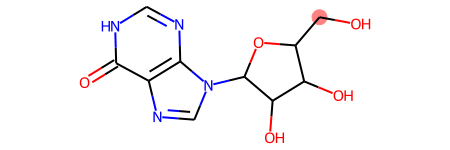

In [34]:
#hier das problem: man kann keine entscheidung faellen, in welche kette der cc sich fortsetzt
mol1.GetSubstructMatches(substructure1)
mol1

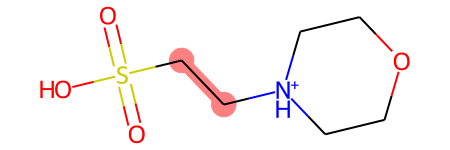

In [35]:
mol2.GetSubstructMatches(substructure1)
mol2

In [36]:
ccore = MolFragmentToCXSmiles(mol1, mol1.GetSubstructMatch(substructure1), kekuleSmiles = True, isomericSmiles=False)
ccoremol = Chem.MolFromSmiles(ccore)

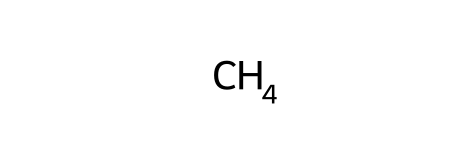

In [37]:
ccoremol

In [38]:
#ccore = MolFragmentToCXSmiles(mol2, mol2.GetSubstructMatch(substructure1), kekuleSmiles = True, isomericSmiles=False)
#ccoremol = Chem.MolFromSmiles(ccore)

In [39]:
#ccoremol

In [40]:
hit_ats1 = mol1.GetSubstructMatch(substructure1)
hit_bonds1 = []
for bond in substructure1.GetBonds():
    aid1 = hit_ats1[bond.GetBeginAtomIdx()]
    aid2 = hit_ats1[bond.GetEndAtomIdx()]
    hit_bonds1.append(mol1.GetBondBetweenAtoms(aid1,aid2).GetIdx())
    

hit_ats2 = mol2.GetSubstructMatch(substructure1)
hit_bonds2 = []
for bond in substructure1.GetBonds():
    aid1 = hit_ats2[bond.GetBeginAtomIdx()]
    aid2 = hit_ats2[bond.GetEndAtomIdx()]
    hit_bonds2.append(mol2.GetBondBetweenAtoms(aid1,aid2).GetIdx())

In [41]:
mol1coreindex = [hit_ats1]
mol2coreindex= [hit_ats2]

In [42]:
from rdkit.Chem.Draw import rdMolDraw2D
d = rdMolDraw2D.MolDraw2DSVG(500, 500)
rdMolDraw2D.PrepareAndDrawMolecule(d, mol1, highlightAtoms=hit_ats1,
                                 highlightBonds=hit_bonds1)

In [43]:
#optionally, add hydrogens
#mol1 = Chem.AddHs(mol1)
#mol2 = Chem.AddHs(mol2)

In [44]:
mol1 = generate_apply_dicts(mol1)
mol2 = generate_apply_dicts(mol2)

In [45]:
graphmol1 = _mol_to_nx_full_weight(mol1)
graphmol2 = _mol_to_nx_full_weight(mol2)

### graphs are created and initialized with weights; now the search for a mutation route starts; first step: find connected dummy regions

In [46]:
subg1, G_dummy1 = _find_connected_dummy_regions_mol(mol1, mol1coreindex, graphmol1)
subg2, G_dummy2 = _find_connected_dummy_regions_mol(mol2, mol2coreindex, graphmol2)


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18]
list_of_dummy_atoms_idx
19
nr_of_dummy_atoms
[13]
list_of_real_atoms_idx
[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11]
list_of_dummy_atoms_idx
12
nr_of_dummy_atoms
[4]
list_of_real_atoms_idx


In [47]:
terminaldummy1, terminalreal1 = _find_terminal_atom(mol1coreindex,  mol1)

In [48]:
matchterminal1 = _match_terminal_real_and_dummy_atoms(mol1, terminalreal1, terminaldummy1)

In [49]:
#not necessary
#matchterminal1 = reduce_terminal(matchterminal1, subg1, G_dummy1)

### call mutation route algorithms

In [50]:
order1 = _calculate_order_of_LJ_mutations(
    subg1, matchterminal1, graphmol1
)

In [51]:
order1new = _calculate_order_of_LJ_mutations_new(
    subg1, matchterminal1, graphmol1
)

Final mutation route:
[0, 2, 3, 1, 4, 6, 7, 5, 8, 9, 18, 16, 17, 10, 11, 15, 12]
Final mutation route:
[14]


In [52]:
order1newiter = _calculate_order_of_LJ_mutations_new_iter(
    subg1, matchterminal1, graphmol1
)

Final mutation route:
[0, 2, 3, 1, 4, 6, 7, 5, 8, 9, 18, 16, 17, 10, 15, 11, 12]
Final mutation route:
[14]


In [53]:
print("compare routes:")
print("dfs/transformato:")
print(order1)
print("bfs/dijkstra:")
print(order1new)
print("bfs/dijkstra iterated:")
print(order1newiter)

compare routes:
dfs/transformato:
[[18, 16, 15, 17, 8, 7, 6, 0, 1, 2, 3, 4, 5, 9, 10, 11, 12], [14]]
bfs/dijkstra:
[[0, 2, 3, 1, 4, 6, 7, 5, 8, 9, 18, 16, 17, 10, 11, 15, 12], [14]]
bfs/dijkstra iterated:
[[0, 2, 3, 1, 4, 6, 7, 5, 8, 9, 18, 16, 17, 10, 15, 11, 12], [14]]


### visualize created routes

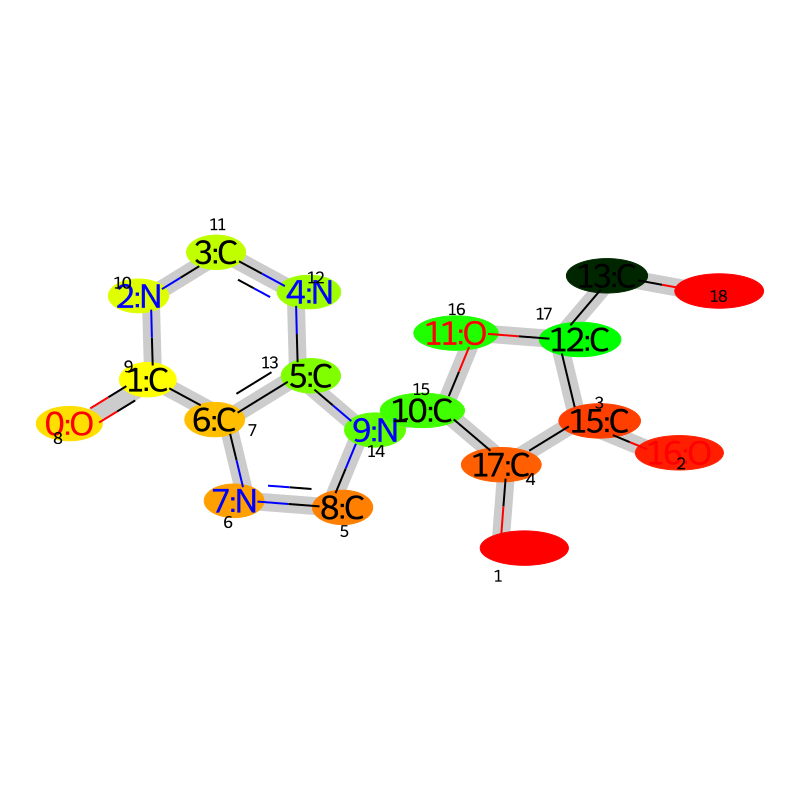

In [54]:
svmol1 = _show_common_core_gradient( mol1, hit_ats1, order1, percomponent = True, numbers = True)
SVG(svmol1)

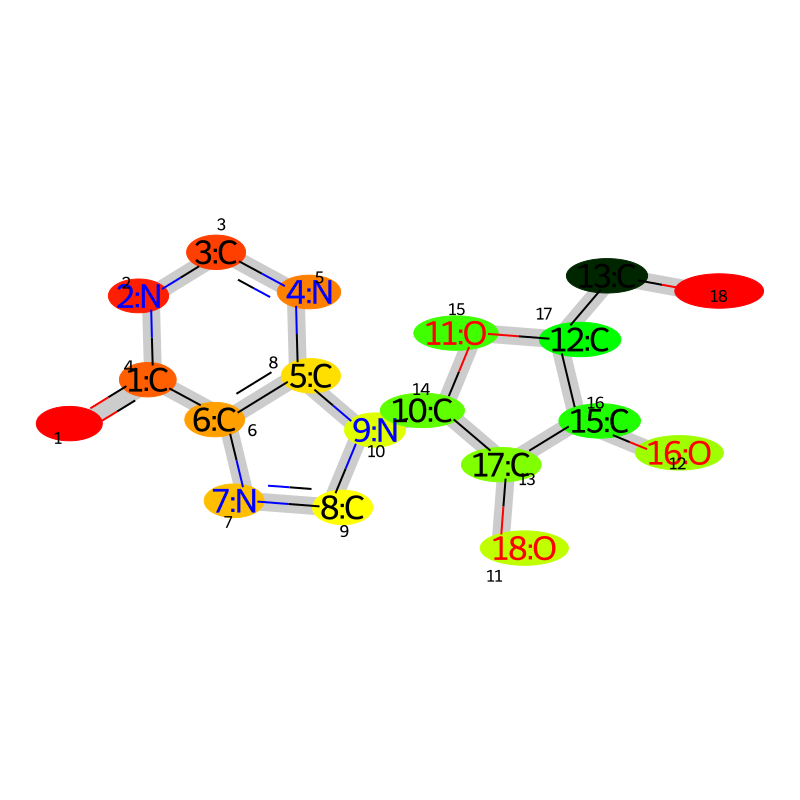

In [55]:
svmol1new = _show_common_core_gradient( mol1, hit_ats1, order1new, percomponent = True, numbers = True)                   
SVG(svmol1new)

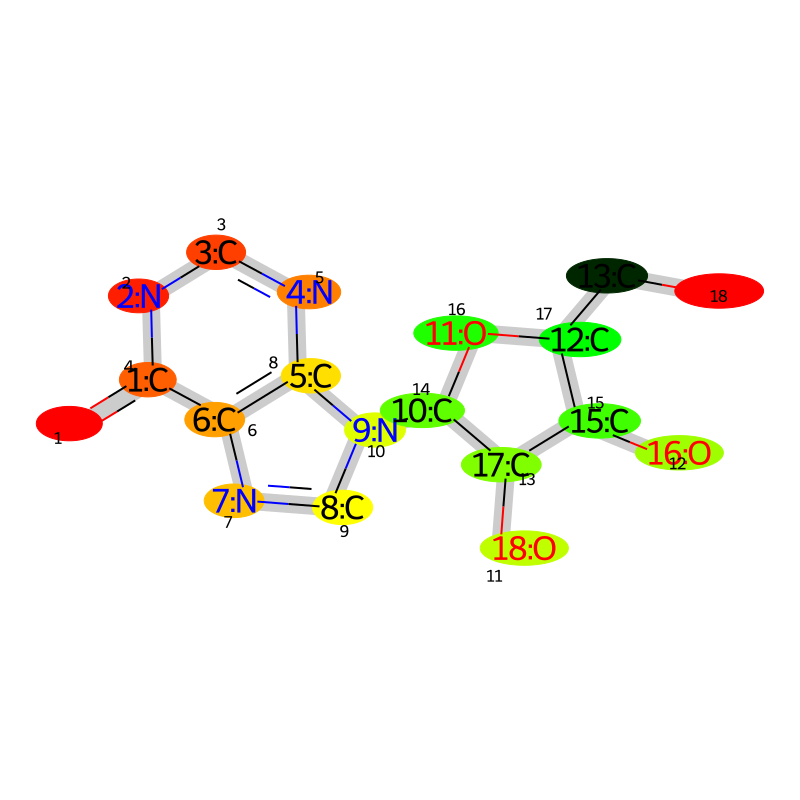

In [56]:
svmol1new_iter = _show_common_core_gradient( mol1, hit_ats1, 
                                         order1newiter, percomponent = True, numbers = True)
SVG(svmol1new_iter)